# Nav

![](https://imgs.xkcd.com/comics/coordinate_precision.png)

## Geocentric and Geodetic Latitudes

| | | |
|---|---|---|
| Geocentric Latitude | $\lambda$ | the angle subtended by the radius vector from the Earth center to the surface point with the equatorial plane |
| Geodetic Latitude   | $\mu$     | the angle subtended by the surface normal vector n and the equatorial plane |

$$
\begin{align}
\lambda_s &= \arctan((1-f)^2 \tan(\mu)) \\
r_s &= \sqrt {\frac {R^2} {1+(1/(1-f)^2-1) \sin^2 (\lambda_s)}} \\
P_{ECEF} &= \begin{bmatrix} p_x & p_y & p_z \end{bmatrix}^T \\
p_x &= r_s \cos(\lambda_s) \cos(i)+h \cos(\mu) \cos(i) \\
p_y &= r_s \cos(\lambda_s) \sin(i)+h \cos(\mu) \sin(i) \\
p_z &= r_s \sin(\lambda_s) + h \sin(\mu) 
\end{align}
$$


```python
def gps2ecef(lat, lon, H):
    # matlab: https://www.mathworks.com/help/aeroblks/llatoecefposition.html
    # this works, matches: https://www.oc.nps.edu/oc2902w/coord/llhxyz.htm
    mu = lat*pi/180
    i = lon*pi/180
    r = 6378137 # Radius of the planet at its equator in meters
    f = 1/298.257223563 # flattening
    ls = atan((1-f)**2 * tan(mu))
    rs = sqrt(r**2 / (1+ (1/(1-f)**2 - 1)*sin(ls)**2))

    x = rs*cos(ls)*cos(i) + H*cos(mu)*cos(i)
    y = rs*cos(ls)*sin(i) + H*cos(mu)*sin(i)
    z = rs*sin(ls)+H*sin(mu)

    return x,y,z
```

## Error Cov

- [ros answers][2]

- [swift navigation][3]

- `COVARIANCE_TYPE_APPROXIMATED = 1`: Another use case would be for when your receiver outputs [Dilution of Precision][1]. If you only get one value, as above, you would take the dilution of precision value (somewhere between 1 `ideal` and >20 `really bad`) and multiply this by the ideal measurement error.
- Example:
    - horizontal measurement error: 1.5m
    - HDOP: 2.3
    - standard dev: 1.5m * 2.3 = 3.45m
    - variance: (3.45m^2) = 11.9m^2
    - do the same for vertical with VDOP



[1]: https://en.wikipedia.org/wiki/Dilution_of_precision_(navigation)
[2]: https://answers.ros.org/question/10310/calculate-navsatfix-covariance/
[3]: https://support.swiftnav.com/support/solutions/articles/44002097796-gnss-receiver-estimated-accuracy-tutorial

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from messages import *
import pickle
import json
import gzip
from pprint import pprint
from nav import *
# from ins_nav import WGS84

In [7]:
with gzip.open('2023-08-06T10:18:09Dtest.json.gzip', 'rt', encoding="ascii") as fd:
    file = json.load(fd)

info = file["info"]
raw_data = file["data"]

# pprint(info)
print("----------------------------------------")
print(f"Loaded {len(data)} data points")

----------------------------------------
Loaded 838 data points


In [9]:
data = []
for vals in raw_data:
    a = vec_t(*vals[0])
    g = vec_t(*vals[1])
    m = vec_t(*vals[2])
    q = quat_t(*vals[3])
    gps = gps_t(*vals[4])
    t = vals[5]
    p = vals[6]
    ts = vals[7]
    msg = msg_t(a,g,m,q,gps,t,p,ts)
    data.append(msg)

In [10]:
print(data[-1])

msg_t(a=vec_t(x=0.055387917906045914, y=-0.01699228584766388, z=0.9902254939079285), g=vec_t(x=0.024902530014514923, y=-0.021085208281874657, z=-0.005899704527109861), m=vec_t(x=-7.006903171539307, y=-69.33798217773438, z=-29.744829177856445), q=quat_t(w=0.9995819330215454, x=-0.0019517620094120502, y=-9.909108901172019e-17, z=-0.0), gps=gps_t(lat=0.0, lon=0.0, altitude=0.0, speed=0.0, satellites=0, fix=0), temperature=25.759803771972656, pressure=103234.4609375, timestamp=3317087)


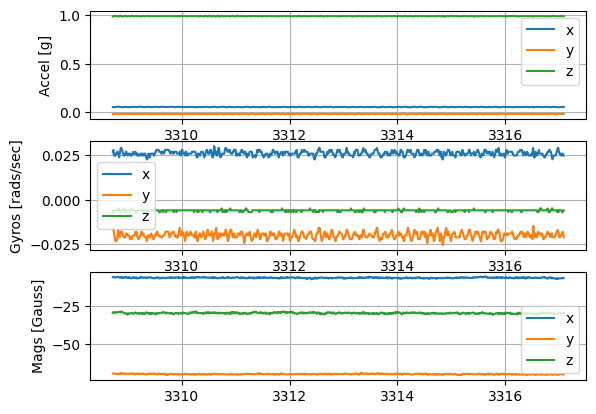

In [11]:
ts = [x.timestamp/1000 for x in data]

plt.subplot(311)
plt.plot(ts, [x.a.x for x in data], label="x")
plt.plot(ts, [x.a.y for x in data], label="y")
plt.plot(ts, [x.a.z for x in data], label="z")
plt.grid(True)
plt.ylabel(("Accel [g]"))
plt.legend();

plt.subplot(312)
plt.plot(ts, [x.g.x for x in data], label="x")
plt.plot(ts, [x.g.y for x in data], label="y")
plt.plot(ts, [x.g.z for x in data], label="z")
plt.grid(True)
plt.ylabel(("Gyros [rads/sec]"))
plt.legend();

plt.subplot(313)
plt.plot(ts, [x.m.x for x in data], label="x")
plt.plot(ts, [x.m.y for x in data], label="y")
plt.plot(ts, [x.m.z for x in data], label="z")
plt.grid(True)
plt.ylabel(("Mags [Gauss]"))
plt.legend();

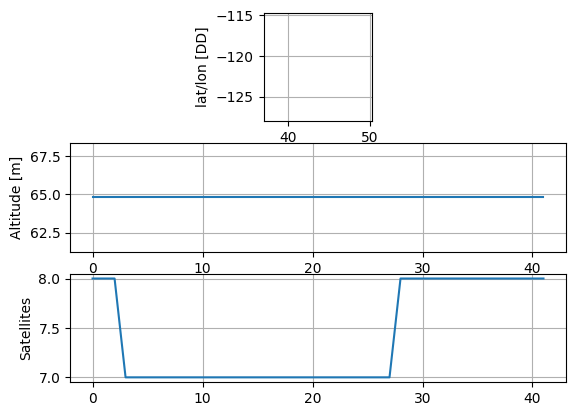

In [12]:
lat = [x.gps.lat for x in data if x.gps.fix == 1]
lon = [x.gps.lon for x in data if x.gps.fix == 1]
alt = [x.gps.altitude for x in data if x.gps.fix == 1]
sat = [x.gps.satellites for x in data if x.gps.fix == 1]
ecef = [gps2ecef(x.gps.lon, x.gps.lat, x.gps.altitude) for x in data]

plt.subplot(311)
plt.plot(lat, lon)
plt.axis('square')
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.ylabel("lat/lon [DD]")

plt.subplot(312)
plt.plot(alt)
plt.grid(True)
plt.ylabel("Altitude [m]")

plt.subplot(313)
plt.plot(sat)
plt.grid(True)
plt.ylabel("Satellites");

In [90]:
accels = [x.a for x in data]
gyros = [x.g for x in data]
stamps = [x.timestamp for x in data]

In [91]:
s = Sim(eom, accels, gyros, stamps)
X, timestamps = s.run_nav()

>> Simulation end: 542682.00 seconds
>> Steps: 19075 at 10.001 sec


In [92]:
vv = [x[0:3] for x in X]
xx = [x[3:6] for x in X]
qq = [x[6:10] for x in X]

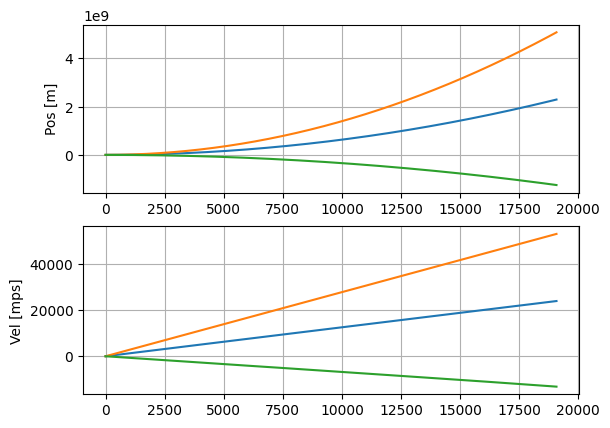

In [93]:
plt.subplot(211)
plt.plot(xx)
plt.grid(True)
plt.ylabel("Pos [m]")

plt.subplot(212)
plt.plot(vv)
plt.grid(True)
plt.ylabel("Vel [mps]");

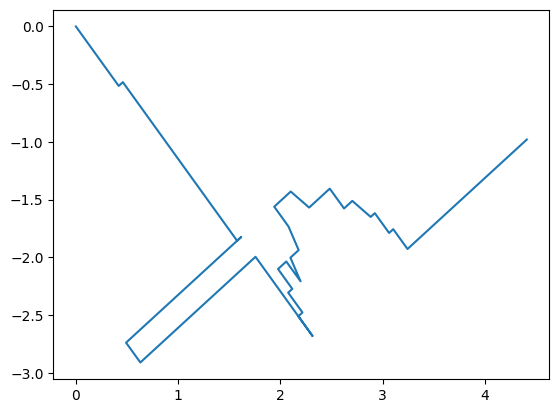

In [106]:
gx = [x[0]-ecef[11][0] for x in ecef if abs(x[2]) > 0]
gy = [x[1]-ecef[11][1] for x in ecef if abs(x[2]) > 0]
plt.plot(gx,gy)

In [107]:
gx[0]

0.0

In [87]:
# from nav import *
gps2ecef(89.9,0,0)

(11169.39217060636, 0.0, 6356742.567109315)

In [108]:
gps2ecef(39,-121,100)

(-2556342.5835983446, -4254468.511741639, 3992379.9547908315)